In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split
from sklearn import utils # used to shuffle data

from keras.preprocessing.image import ImageDataGenerator # used for image augmentation


import tensorflow as tf
# used for building and training a new model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

# import functions from other python files
from code_files.imagePreprocessing import * 

c:\Users\Rebecca\anaconda3\envs\MLEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import images (and labels) and store in dataframe
data_path = 'datasets/cv_data/' #'datasets/handPD/spirals/'

trainImgs = pd.DataFrame()
testImgs  = pd.DataFrame()
trainArray = []
testArray  = []


for dataType in os.listdir(data_path):
    img_path = []
    lbl = []
    lblName = []
    for group in os.listdir(os.path.join(data_path, dataType)):
        for img in os.listdir(os.path.join(data_path, dataType, group)):
            path = os.path.join(data_path, dataType, group, img)
            img_path.append(path) 

            # convert the image and store as a matrix
            drawing = cv2.imread(path)
            drawing = cv2.resize(drawing, (256,256))

            if dataType == 'test':
                testArray.append(drawing)
            else:
                trainArray.append(drawing)

            # store the labels
            if group == 'healthy':
                lbl.append(0)
                lblName.append('healthy')
            else:
                lbl.append(1)
                lblName.append('parkinsons')

    if dataType == 'train':
        trainLbls = lbl
        trainImgs['image'] = img_path
        trainImgs['label'] = lblName
    else:
        testLbls = lbl
        testImgs['image'] = img_path
        testImgs['label'] = lblName

# shuffle the data
trainImgs, trainArray, trainLbls = utils.shuffle(trainImgs, trainArray, trainLbls)
# testImgs, testArray, testLbls = utils.shuffle(testImgs, testArray, testLbls)

# convert labels to categorical for training model
trainLbls_categorical = tf.keras.utils.to_categorical(trainLbls)
print("Lables of first 5 images: \n", trainLbls_categorical[0:5])

Lables of first 5 images: 
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [3]:
# display first five images
print("Lables of first train 5 images: ", trainLbls[0:5])
trainImgs.head()

Lables of first train 5 images:  [0, 1, 0, 1, 0]


,image,label
44,datasets/cv_data/train\healthy\V55HE15.png,healthy
59,datasets/cv_data/train\parkinsons\V04PE03.png,parkinsons
28,datasets/cv_data/train\healthy\V11HE03.png,healthy
61,datasets/cv_data/train\parkinsons\V05PE02.png,parkinsons
32,datasets/cv_data/train\healthy\V55HE01.png,healthy


In [4]:
print("Test labels: ", testLbls)
display(testImgs)

Test labels:  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


,image,label
0,datasets/cv_data/test\healthy\V04HE01.png,healthy
1,datasets/cv_data/test\healthy\V07HE01.png,healthy
2,datasets/cv_data/test\healthy\V10HE01.png,healthy
3,datasets/cv_data/test\healthy\V11HE01.png,healthy
4,datasets/cv_data/test\healthy\V55HE12.png,healthy
5,datasets/cv_data/test\healthy\V55HE14.png,healthy
6,datasets/cv_data/test\parkinsons\V01PE01.png,parkinsons
7,datasets/cv_data/test\parkinsons\V03PE07.png,parkinsons
8,datasets/cv_data/test\parkinsons\V04PE01.png,parkinsons
9,datasets/cv_data/test\parkinsons\V08PE01.png,parkinsons


In [5]:
# create the convolutional base network for VGG16
VGG16_conv_base = VGG16(weights='imagenet', include_top=False,input_shape=(256,256,3))
VGG16_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [6]:
# define a function that will extract the features from conv network
def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255) # define to rescale pixels in image
    batch_size = 10
    
    features = np.zeros(shape=(num_imgs, 8,8,512)) # shape equal to output of convolutional base
    lbls = np.zeros(shape=(num_imgs,2))

    # preprocess data
    generator = datagen.flow_from_dataframe(imgs, x_col = 'image', y_col='label', target_size=(256,256), class_mode='categorical', batch_size=batch_size)

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = VGG16_conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

In [8]:
train_feat, train_lbls = extract_features(trainImgs, 90)
test_feat, test_lbls = extract_features(testImgs, 12)

Found 90 validated image filenames belonging to 2 classes.
1/1 [==============================] - 5s 5s/step
Found 12 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 937ms/step


In [9]:
# evaluate on VGG16 classifier (using cross validation)
# define a function that will fit the model
def defineModel(size):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=(size,size,512)))
    # global average pooling is used instead of fully connected layers on top of the feature maps
    # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
    model.add(Dense(2, activation='softmax'))
    # model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# train the model using cross validation
# will start with k-fold cross validation, taking 80% as training each fold

# define model checkpoint callback
model_chkpt = tf.keras.callbacks.ModelCheckpoint('20221006_VGG16_kfold_folDS.h5', verbose=0, save_best_only=True)

def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, test_feat, test_lbls, epochs):
    model = None
    model = defineModel(8)
    trained_model = model.fit(train_feat, train_lbls, batch_size=10, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

    # testScore = model.evaluate(test_feat, test_lbls)
    return trained_model

In [12]:
# train with k-fold validation
model_history = []

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

for i in range(k):
    print("Training on fold K = ", i+1)
    startPt = i * num_val_samples
    endPt   = (i+1) * num_val_samples

    val_x = train_feat[startPt:endPt]
    val_y = train_lbls[startPt:endPt]
    train_x = np.delete(train_feat, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0)
    train_y = np.delete(train_lbls, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0)

    model_history.append(fit_and_evaluate(train_x, train_y, val_x, val_y, test_feat, test_lbls, epochs=250))
    # print(model_history)
    
    print("======="*12, end="\n")
    

Training on fold K =  1
Training on fold K =  2
Training on fold K =  3
Training on fold K =  4
Training on fold K =  5


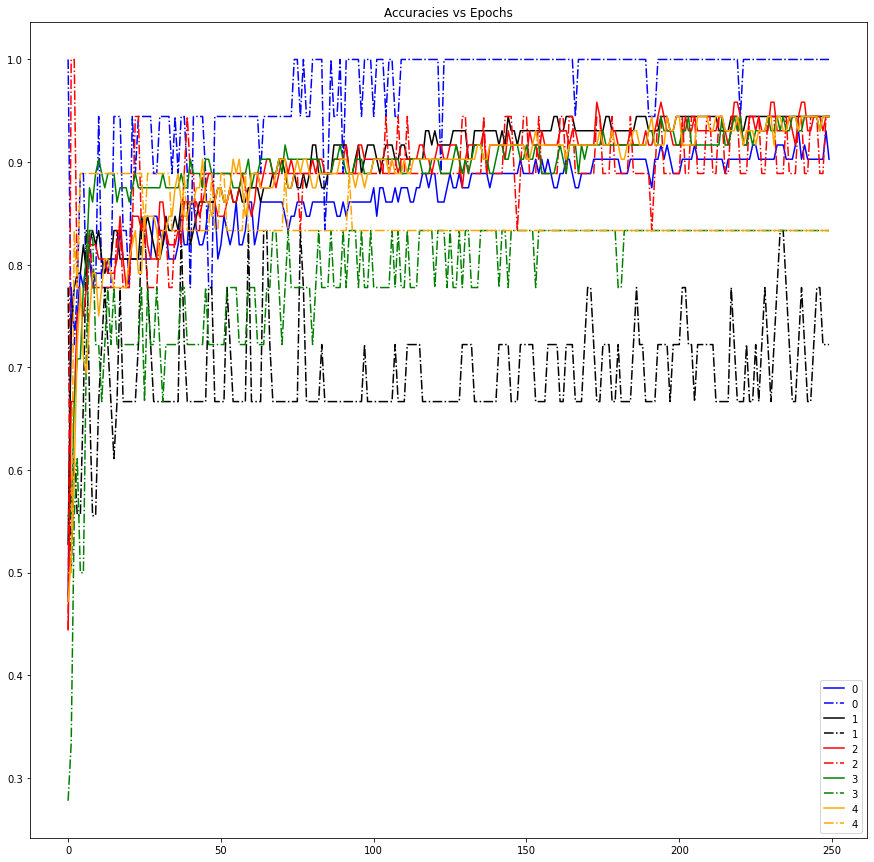

In [13]:
color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
plt.figure(figsize=(15,15))
plt.title('Accuracies vs Epochs')
for i in range(k):
    plt.plot(model_history[i].history['accuracy'], label=i, color=color[i])
    plt.plot(model_history[i].history['val_accuracy'], label=i, linestyle= 'dashdot', color=color[i])
plt.legend()
plt.show()

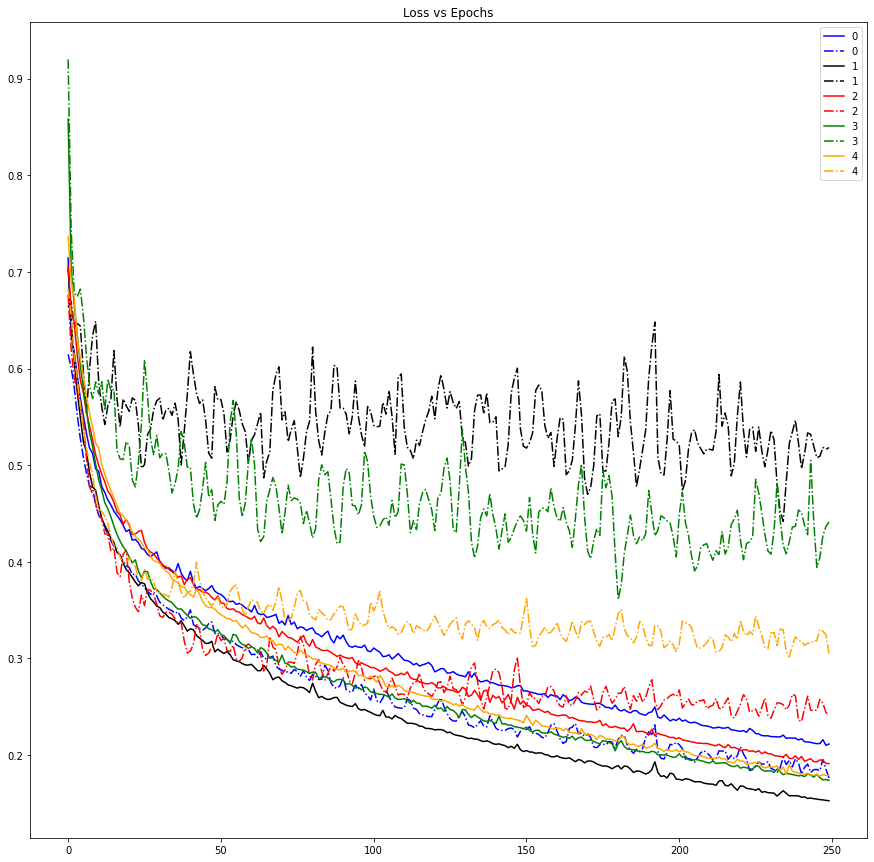

In [14]:
plt.figure(figsize=(15,15))
plt.title('Loss vs Epochs')
for i in range(k):
    plt.plot(model_history[i].history['loss'], label=i, color=color[i])
    plt.plot(model_history[i].history['val_loss'], label=i, linestyle= 'dashdot', color=color[i])
plt.legend()
plt.show()

In [15]:
# ---------------------------------------------------------------------------------------
#                             LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------------------------------------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/saved_h5_models/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    return testModel

In [16]:
# load existing model and evaluate the test data

# covert label array to binary class matrix (healthy, PD)
# testLbl_categorical = tf.keras.utils.to_categorical(np.array(testLbl))
# test, testLbl = utils.shuffle(test, testLbl)
model = importModel('20221006_VGG16_kfold_folDS.h5', test_feat, test_lbls)

1/1 - 0s - loss: 0.4847 - accuracy: 0.7500 - 98ms/epoch - 98ms/step
Loss:  0.48472461104393005 | Accuracy:  0.75


In [18]:
def plotMisclassImgs(testModel, test_feat, test_label, test_array):
    test_label = np.array(test_label)
    incorrectImgs = []
    incorrectImgIdx = []

    count = 0
    fig, axes = plt.subplots(2, 6, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(test_array, axes):
        ax.imshow(np.squeeze(img), cmap="gray") # plot image

        # use the model to predict the label
        predImg = testModel.predict(np.expand_dims(test_feat[count], axis=0), verbose=0) # use for grayscale
        # predImg = testModel.predict(test_feat[count])                       # use for RGB
        predLabel = np.argmax(predImg[0])       
        
        if test_label[count] != predLabel:
            ax.set_title('Label: ' + str(test_label[count]) + ' | Pred: ' + str(predLabel), color='red')
            # save off image to array
            incorrectImgs.append(test_array[count])
            incorrectImgIdx.append(count)
        else:
            ax.set_title('Label: ' + str(test_label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

    return np.array(incorrectImgs), np.array(incorrectImgIdx), testModel.predict(test_feat)

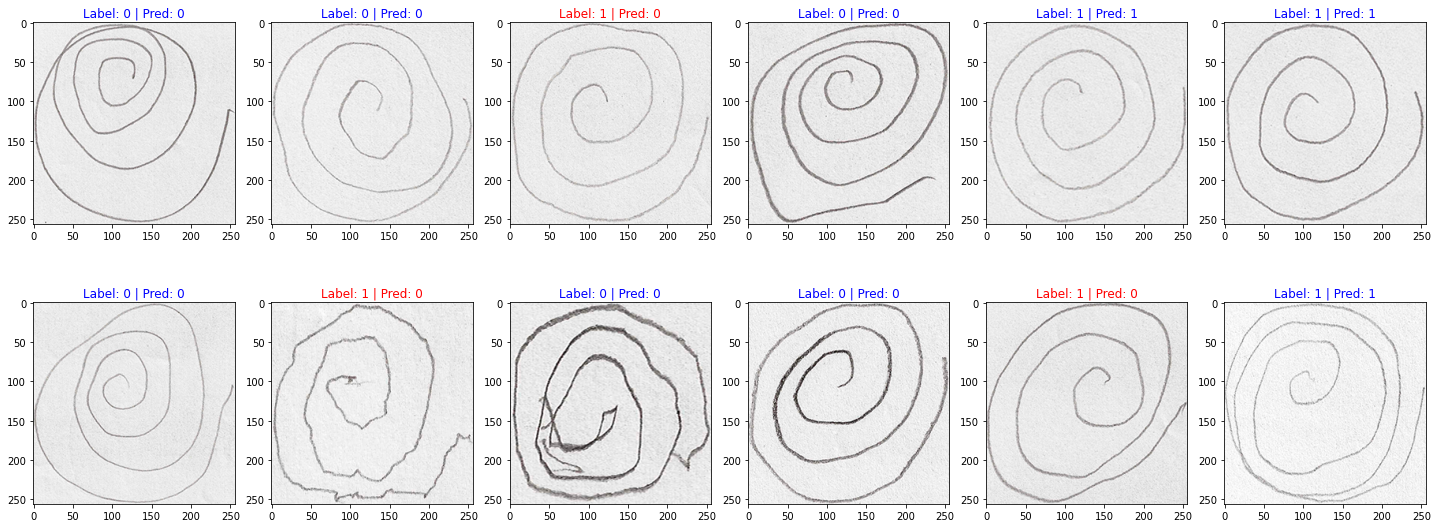

1/1 [==============================] - 0s 17ms/step
[[0.9181684  0.08183155]
 [0.98040074 0.01959919]
 [0.8583359  0.14166409]
 [0.751698   0.24830194]
 [0.29955453 0.7004455 ]
 [0.06909096 0.930909  ]
 [0.8774114  0.12258852]
 [0.7647572  0.23524284]
 [0.58591425 0.4140858 ]
 [0.96296304 0.03703693]
 [0.5899618  0.4100382 ]
 [0.00243099 0.997569  ]]


In [19]:
# plot the results
misClass_test, misClass_idx, predictions = plotMisclassImgs(model, test_feat, np.argmax(test_lbls, axis=1), testArray)
print(predictions)